## Arboles de decisión clasificación de música

https://www.aprendemachinelearning.com/arbol-de-decision-en-python-clasificacion-y-prediccion/

Utilicé python para hacer webscraping de una web pública **«Ultimate Music Database»** con información histórica del Billboard de este artículo: **«Analyzing billboard 100″**. Se completaron los atributos utilizando la **API de Deezer** (duración de las canciones), la **API de Gracenote** (género y ritmo de las canciones). Finalmente se completo a mano varias fechas de nacimiento de artistas utilizando la **Wikipedia** que no había conseguido con la Ultimate Music Database. Algunos artistas quedaron sin completar su fecha de nacimiento y con valor 0. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

## Análisis exploratorio inicial

In [4]:
artists_billboard = pd.read_csv('../datasets/artists_billboard_fix3.csv')
artists_billboard.shape

(635, 11)

In [5]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


Vemos que tenemos: Titulo de la canción, artista, «mood» ó estado de ánimo de esa canción, tempo, género, Tipo de artista, fecha en que apareció en el billboard (por ejemplo 20140628 equivale al 28 de junio de 2014), la columna TOP será nuestra etiqueta, en la que aparece 1 si llegó al número uno de Billboard ó 0 si no lo alcanzó y el anio de Nacimiento del artista. Vemos que muchas de las columnas contienen información categórica. La columna durationSeg contiene la duración en segundos de la canción, siendo un valor continuo pero que nos convendrá pasar a categórico más adelante.

In [13]:
artists_billboard.groupby('top').count()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,anioNacimiento
top,,,,,,,,,,
0,494,494,494,494,494,494,494,494,494,494
1,141,141,141,141,141,141,141,141,141,141


Es decir que tenemos 494 canciones que no alcanzaron la cima y a 141 que alcanzaron el número uno. Esto quiere decir que tenemos una cantidad DESBALANCEADA de etiquetas con 1 y 0. Lo tendremos en cuenta al momento de crear el árbol.

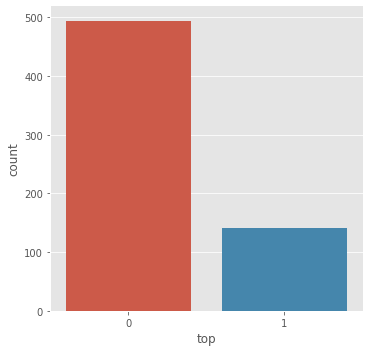

In [16]:
sb.catplot('top',data=artists_billboard,kind="count")

Nuestras etiquetas que indican 0-No llego al Top y 1-Llego al número uno Billboard están desbalanceadas. Deberemos resolver este inconveniente

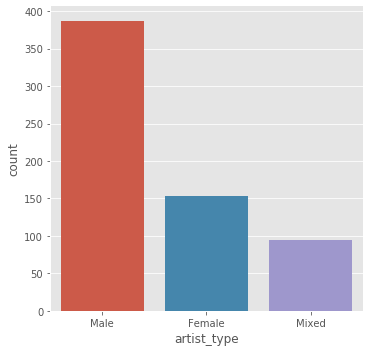

In [15]:
sb.catplot('artist_type',data=artists_billboard,kind="count")

Aqui vemos que tenemos más del doble de artistas masculinos que femeninos y unos 100 registros de canciones mixtas

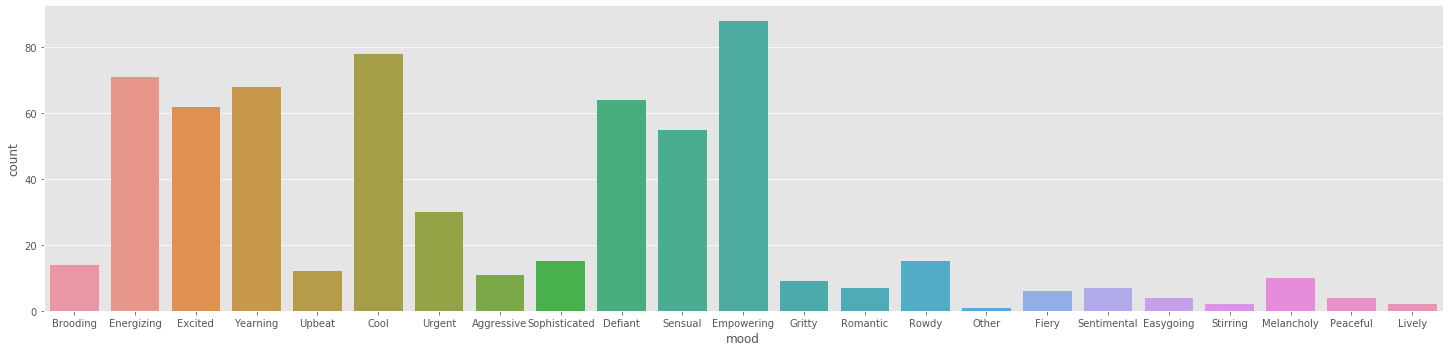

In [20]:
sb.factorplot('mood',data=artists_billboard,kind="count", aspect=4)

Vemos que de 23 tipos de Mood, destacan 7 con picos altos. Además notamos que algunos estados de ánimo son similares

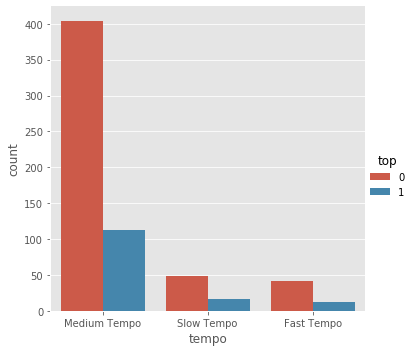

In [21]:
sb.factorplot('tempo',data=artists_billboard,hue='top',kind="count")

En esta gráfica vemos que hay 3 tipos de Tempo: Medium, Slow y Fast. Evidentemente predominan los tiempos Medium y también es donde encontramos más canciones que hayan alcanzado el Top 1 (en azul)

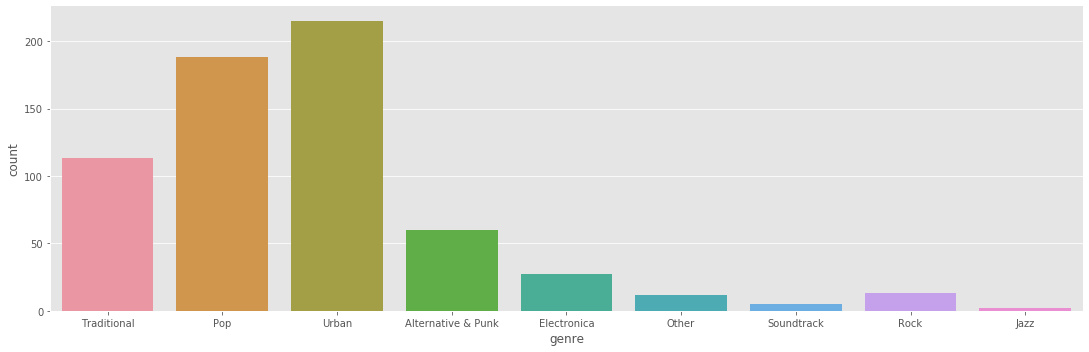

In [22]:
sb.factorplot('genre',data=artists_billboard,kind="count", aspect=3)

Entre los géneros musicales destacan Urban y Pop, seguidos de Tradicional.

Veamos ahora que pasa al visualizar los años de nacimiento de los artistas:

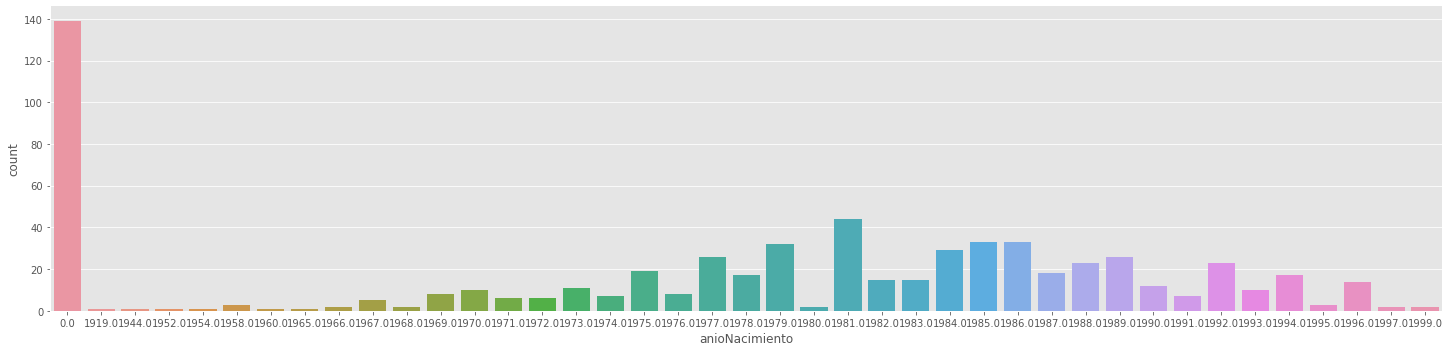

In [25]:
sb.factorplot('anioNacimiento',data=artists_billboard,kind="count", aspect=4)

Aqui notamos algo raro: en el año «cero» tenemos cerca de 140 registros…
Como se ve en la gráfica tenemos cerca de 140 canciones de las cuales desconocemos el año de nacimiento del artista. El resto de años parecen concentrarse entre 1979 y 1994

## Balanceo de datos

No tenemos «equilibrio» en la cantidad de etiquetas top y «no-top» de las canciones. Esto se debe a que en el transcurso de un año, apenas unas 5 o 6 canciones logran el primer puesto y se mantienen durante varias semanas en ese puesto. Al inicio de la extracción, se utilizó 2014 y 2015 y tenía apenas a 11 canciones en el top de Billboard y 494 que no llegaron.

Para intentar equilibrar los casos positivos se agrego solamente los TOP de los años 2004 al 2013. Con eso los valores en el archivo csv: son 494 «no-top» y 141 top. A pesar de esto sigue estando desbalanceado, utilizaremos un parámetro (class_weight) del algoritmo de árbol de decisión para compensar esta diferencia.

In [43]:
f1 = artists_billboard['chart_date'].values
f2 = artists_billboard['durationSeg'].values
 
colores=['orange','blue'] # Canciones que llegaron al top en azul
tamanios=[60,5] # Más pequeño los que llegan al top
 
asignar=[]
asignar2=[]
for index, row in artists_billboard.iterrows():    
    asignar.append(colores[row['top']])
    asignar2.append(tamanios[row['top']])

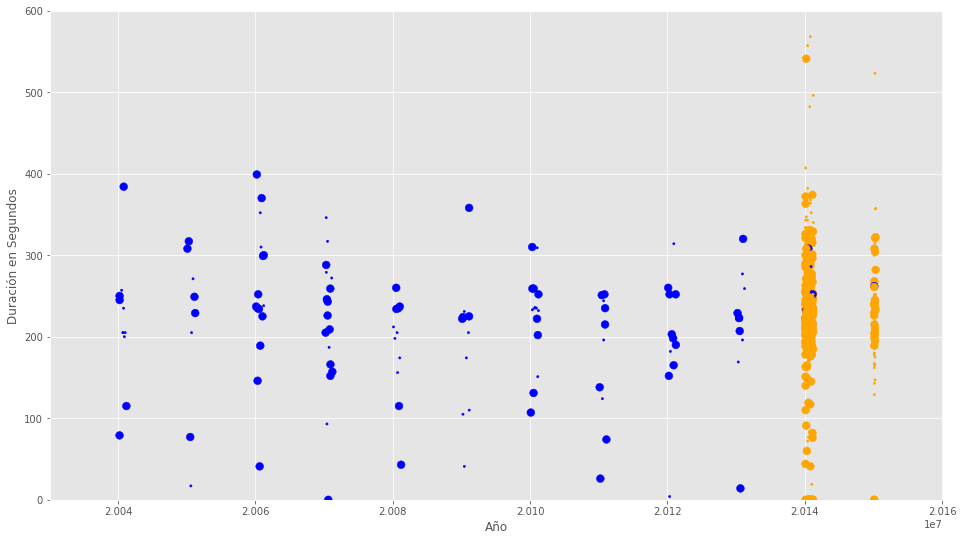

In [44]:
plt.scatter(f1, f2, c=asignar, s=tamanios)
plt.axis([20030101,20160101,0,600])
plt.xlabel('Año')
plt.ylabel('Duración en Segundos')
plt.show()

En nuestro conjunto de Datos, se agregaron canciones que llegaron al top (en azul) de años 2004 al 2013 para sumar a los apenas 11 que lo habían logrado en 2014-2015.